In [1]:
import pandas as pd
import pandas_datareader as data
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [86]:
start_date = '1928-01-01'
end_date = '2022-08-01'
years = 30
tax = 0.2
init_amount = 0
max_amount = 10000000
step = 50000
monthly = 8000
min_amount_tolerable = 500000
inflation_on = True

data_source = 'yahoo'
sap500 = '^GSPC'
dow = '^DJI'

result_df = pd.DataFrame(columns = ['start_date','principle','monthly','months_survive','survive'])

In [87]:
# pull raw data
cpi = data.DataReader("CPIAUCNS", "fred", start_date, end_date)
stock = data.DataReader(sap500, data_source, start_date, end_date)[['Close']]


# user merger and then fill in monthly from the previous close if possible else the next close
df = cpi.merge(stock, how='outer', left_index=True, right_index=True)
df[['Close']] = df[['Close']].fillna(method='ffill').fillna(method='bfill')

# remove non first month 
df.dropna(inplace=True)

# set placeholders
df['inflation'] = 0.0
df['change'] = 0.0
df.reset_index(inplace=True)
df.head()

,index,CPIAUCNS,Close,inflation,change
0,1928-01-01,17.3,17.760000,0.0,0.0
1,1928-02-01,17.1,17.530001,0.0,0.0
2,1928-03-01,17.1,17.299999,0.0,0.0
3,1928-04-01,17.1,19.280001,0.0,0.0
4,1928-05-01,17.2,19.780001,0.0,0.0


In [88]:
# calculate baseline df
for i in range(len(df)):
    # skip the first iteration
    if i == 0: continue
    # update inflation
    if inflation_on:
        p_cpi = df.at[i-1,'CPIAUCNS']
        c_cpi = df.at[i,'CPIAUCNS']
        df.at[i,'inflation']= (c_cpi - p_cpi)/p_cpi
    # update percent change
    p_close = df.at[i-1,'Close']
    c_close = df.at[i,'Close']
    df.at[i,'change'] = (c_close - p_close)/p_close

In [89]:
def model_year(prin, start_date_index, withdrawal, df):
    global result_df
    # calculates the model year and inserts into results df
    # returns boolean for making it to the end of the year
    failed = False
    s_date = df.at[start_date_index,'index'].strftime('%Y_%m_%d')
    mnth = f'monthly_{s_date}_{prin}'
    prcp = f'principle_{s_date}_{prin}'
    df[mnth] = np.nan
    df[prcp] = np.nan
    k=0
    end = start_date_index + years*12 +1
    start = df.at[start_date_index,'index']
    for i in range(start_date_index,end):
        if k==0:
            df.at[i,mnth]= withdrawal
            df.at[i,prcp]= prin
            k+=1
            continue
        if i > len(df):
            break
        p = i-1
        # previous monthly * (1+inflation)
        p_m = df.at[p,mnth]
        c_i = df.at[i,'inflation']
        c_m = p_m*(1+c_i)
        df.at[i,mnth]= c_m
        # (previous principle*(1+change)) - current monthly
        p_p = df.at[p,prcp]
        p_c = df.at[p,'Close']
        c_c = df.at[i,'Close']
        change =  (c_c-p_c)/p_c
        c_p = p_p*(1+change)-c_m
        df.at[i,prcp]= c_p
        failed = (c_p <= min_amount_tolerable)
        if failed or i == end-1:
            res = pd.DataFrame.from_dict({'start_date': [start], 'principle': prin, 'monthly': withdrawal,'months_survive': [i-start_date_index], 'survive': [not failed]})
            result_df = pd.concat([result_df,res], ignore_index=True)
            break
    df.drop(columns=[mnth], inplace=True)
    return failed
    

In [90]:
# Testing
# model_year(init_amount, 0, 8000, df)
# result_df.head()

In [91]:
def seek_year(sdi, p_min, p_max, step, withdrawal, baseline_df):
    # sdi = start date index 
    # p_min = principle min
    # p_max = principle max
    # step = increase step from in to max
    
    # presumes failed state
    failed = True
    for prin in range(p_min,p_max,step):
        failed = model_year(prin, sdi, withdrawal, baseline_df)
        # exists when succeeds
        if not failed:
            break

In [92]:
# Testing
# seek_year(0, init_amount, max_amount, step, monthly,df)
# result_df.head()

In [93]:
%%time

lsi = int((len(df)- years*12)/12)
for s in range(lsi):
    s_date_i = s*12
    year = df.at[s_date_i,'index'].strftime('%Y_%m_%d')
    print(f'analyzing year: {year}')
    seek_year(s_date_i, init_amount, max_amount, step, monthly,df)

analyzing year: 1928_01_01
analyzing year: 1929_01_01
analyzing year: 1930_01_01
analyzing year: 1931_01_01
analyzing year: 1932_01_01
analyzing year: 1933_01_01
analyzing year: 1934_01_01
analyzing year: 1935_01_01
analyzing year: 1936_01_01
analyzing year: 1937_01_01
analyzing year: 1938_01_01
analyzing year: 1939_01_01
analyzing year: 1940_01_01
analyzing year: 1941_01_01
analyzing year: 1942_01_01
analyzing year: 1943_01_01
analyzing year: 1944_01_01
analyzing year: 1945_01_01
analyzing year: 1946_01_01
analyzing year: 1947_01_01
analyzing year: 1948_01_01
analyzing year: 1949_01_01
analyzing year: 1950_01_01
analyzing year: 1951_01_01
analyzing year: 1952_01_01
analyzing year: 1953_01_01
analyzing year: 1954_01_01
analyzing year: 1955_01_01
analyzing year: 1956_01_01
analyzing year: 1957_01_01
analyzing year: 1958_01_01
analyzing year: 1959_01_01
analyzing year: 1960_01_01
analyzing year: 1961_01_01
analyzing year: 1962_01_01
analyzing year: 1963_01_01
analyzing year: 1964_01_01
a

<AxesSubplot:title={'center':'principle needed (inflation on, monthly 8000, min_bal 500000)'}, ylabel='Frequency'>

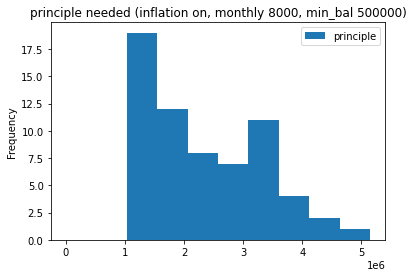

In [94]:
inf_text= 'on' if inflation_on else 'off'
title = f'principle needed (inflation {inf_text}, monthly {monthly}, min_bal {min_amount_tolerable})'
xl='Principle [$]'

result_df[result_df.survive].plot.hist(column=["principle"], title=title, xlabel=xl)

In [96]:
pd.to_numeric(result_df[result_df.survive]['principle']).describe()

count    6.400000e+01
mean     2.359375e+06
std      1.004864e+06
min      1.200000e+06
25%      1.487500e+06
50%      2.100000e+06
75%      3.112500e+06
max      5.150000e+06
Name: principle, dtype: float64

In [97]:
result_df

,start_date,principle,monthly,months_survive,survive
0,1928-01-01 00:00:00,0,8000,1,False
1,1928-01-01 00:00:00,50000,8000,1,False
2,1928-01-01 00:00:00,100000,8000,1,False
3,1928-01-01 00:00:00,150000,8000,1,False
4,1928-01-01 00:00:00,200000,8000,1,False
...,...,...,...,...,...
3079,1991-01-01 00:00:00,1150000,8000,249,False
3080,1991-01-01 00:00:00,1200000,8000,283,False
3081,1991-01-01 00:00:00,1250000,8000,309,False
3082,1991-01-01 00:00:00,1300000,8000,349,False
